# Implementing LSTNet for Time-Series Forecasting

**Key Deadlines:**

    * Presentation (20%): 8, 15 Apr 2023 (Last two classes, all slides due 8 April)
    * Report (30%): Due 22 Apr 2023

**Implementation Notes:**

    * Completed implementation of Basic Time Series Analysis Functions/Exploratory Data Analysis.
    * Tested implementation of GASF/GADF transformation from pyts package on full time series data.
    * Implemented core functions for working with time series data for deep learning models (window functions, training-validation split and one-step forecasting function). Core helper functions implemented based on labs from the Coursera module: Sequences, Time Series and Predictions. See https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction
    * Tested one step forecast on univariate dataset using a simple NN model.
    * Integrated the LSTNet model from the following repository: https://github.com/flaviagiammarino/lstnet-tensorflow
    * Modified to include Multi-Head Attention Mechanism.
    * Tested LSTNet model on one-step forecast for univariate time series.
    * Implement evaluation metrics used in paper - Root Relative Squared Error (RSE) and Empirical Correlation Coefficient (CORR)
    * Propose model modification to allow for accepting GASF/GADF image as input.
    * Calling model.fit must be run on the windowed time series dataset of GASF/GADF images. i.e. propose a revision to the windowed_dataset function to transform windowed training data.
    * Updated windowed_GAF_generator for mean normalization on the labels.

**Additional Works to be Completed:**
    
    * Implementing a revised model_forecast() function for performing h-step forecasting. Test and visualize.
    * Hyperparameter tuning for baseline LSTM model.
    * Test proposed implementation for univariate case.
    * Conduct ablative studies.
    * Study generalizations for accepting multivariate time series data.
    * Evaluate performance on additional evaluation metrics (RSE and CORR)

## Importing Required Libraries

In [ ]:
#!pip install statsmodels
#!pip install pyts

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os

# Time-Series Analysis Libraries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# LSTNet Required Libraries
from tensorflow.keras.layers import MultiHeadAttention

In [52]:
from pyts.image import GramianAngularField

## Loading Electricity Dataset

The raw dataset is available at https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014. This is a **_multivariate time series dataset_**, containing electricity consumption data in kWh, recorded every 15 minutes from 2011 to 2014. The final dataset contains the electricity consumption data of 321 clients from 2012 to 2014, and converted to reflect hourly consumption.

In [ ]:
# Downloading Electricity Dataset (RUN THIS ONCE THEN UNCOMMENT)
#!wget https://github.com/laiguokun/multivariate-time-series-data/raw/master/electricity/electricity.txt.gz
#!gzip -d electricity.txt.gz

## Exploratory Data Analysis

In [2]:
# Load dataset
dataset = pd.read_csv('electricity.txt', header=None)
print(dataset.shape) # check dimensions
display(dataset.head())

(26304, 321)


,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,320
0,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
3,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
4,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0


In [ ]:
# print(dataset.describe())

# Plot the first 1000 time steps for the first 5 series
fig, ax = plt.subplots(5, 1, figsize=(15, 10))
for i in range(5):
    ax[i].plot(dataset.iloc[:1000, i], label=f'Series {i+1}')
    ax[i].legend(loc='upper right')
plt.show()

## Univariate Time Series Scenario

In [5]:
# Univariate Time Series Analysis
single_series = dataset.iloc[:, 3]

# Create a datetime index
date_rng = pd.date_range(start='2012-01-01', freq='H', periods=len(single_series))
single_series.index = date_rng

# Extract the time and series components
series = single_series.to_numpy()
#time = single_series.index.to_numpy()
time = np.arange(0, len(series))

In [6]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(10, 6))
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

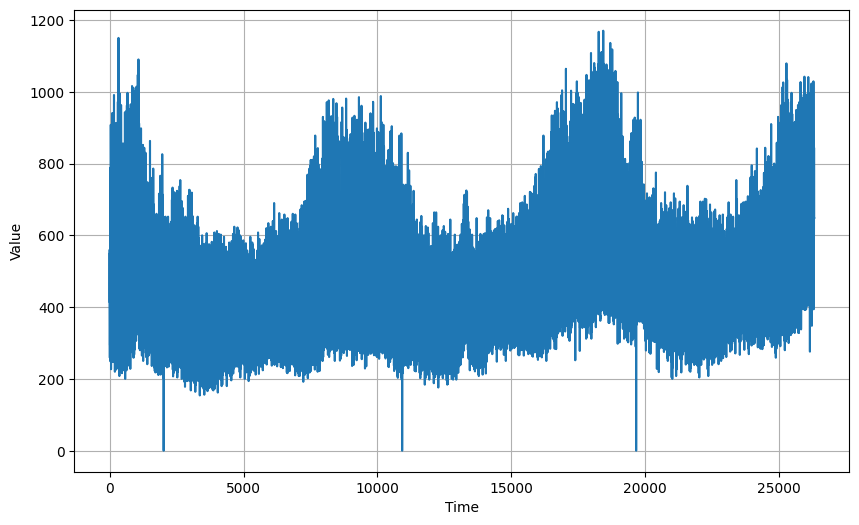

In [7]:
plot_series(time,series)

In [8]:
# Determine the number of years in the dataset
num_years = single_series.index.year.nunique()

# Create subplots for each year
fig, ax = plt.subplots(num_years, 1, figsize=(15, num_years * 5))

for i, year in enumerate(single_series.index.year.unique()):
    yearly_data = single_series[single_series.index.year == year]
    ax[i].plot(yearly_data, label=f'Electricity Consumption ({year})')
    ax[i].set_title(f'Year {year}')
    ax[i].legend()

plt.tight_layout()
plt.show()

## Time Series Analysis - ACF, PACF and Classical Decomposition

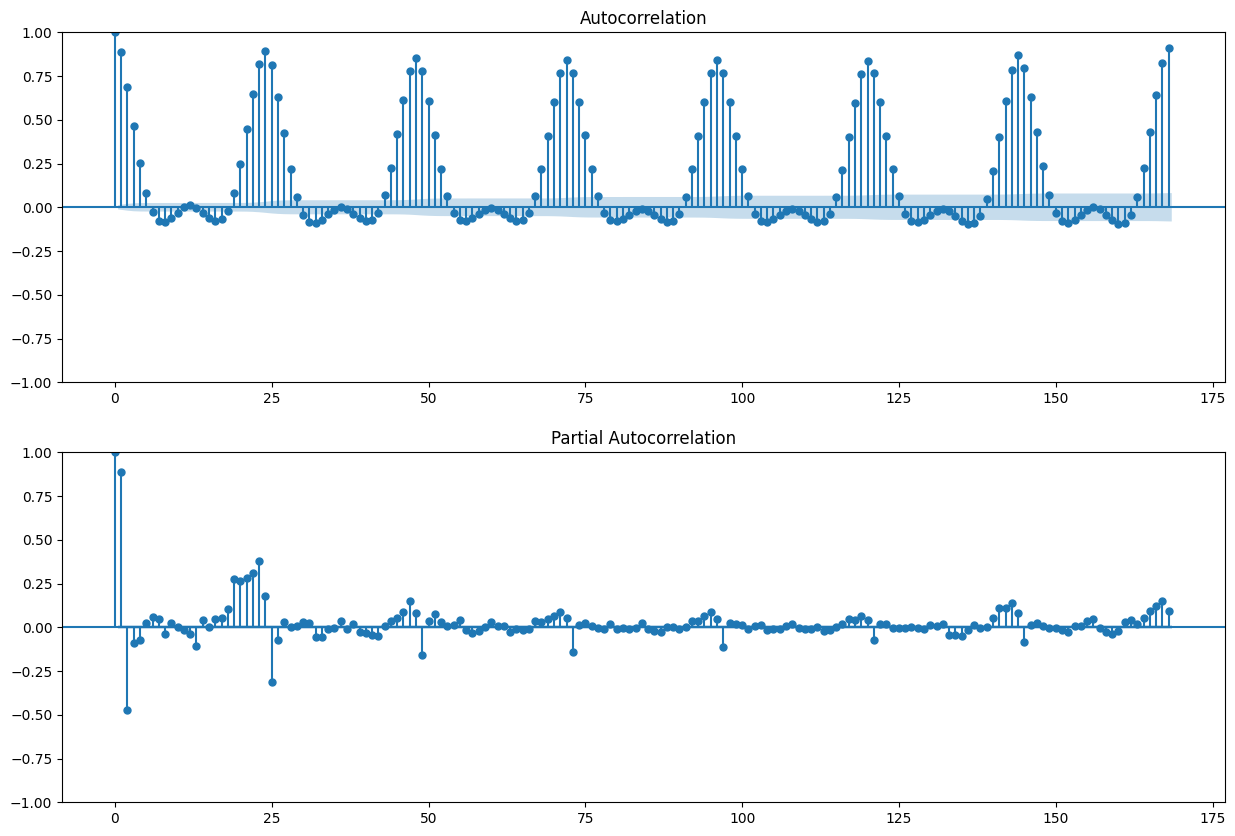

In [9]:
# Visualizing Autocorrelations
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(single_series, lags=168, ax=ax[0])
plot_pacf(single_series, lags=168, ax=ax[1], method='ywm')
plt.show()

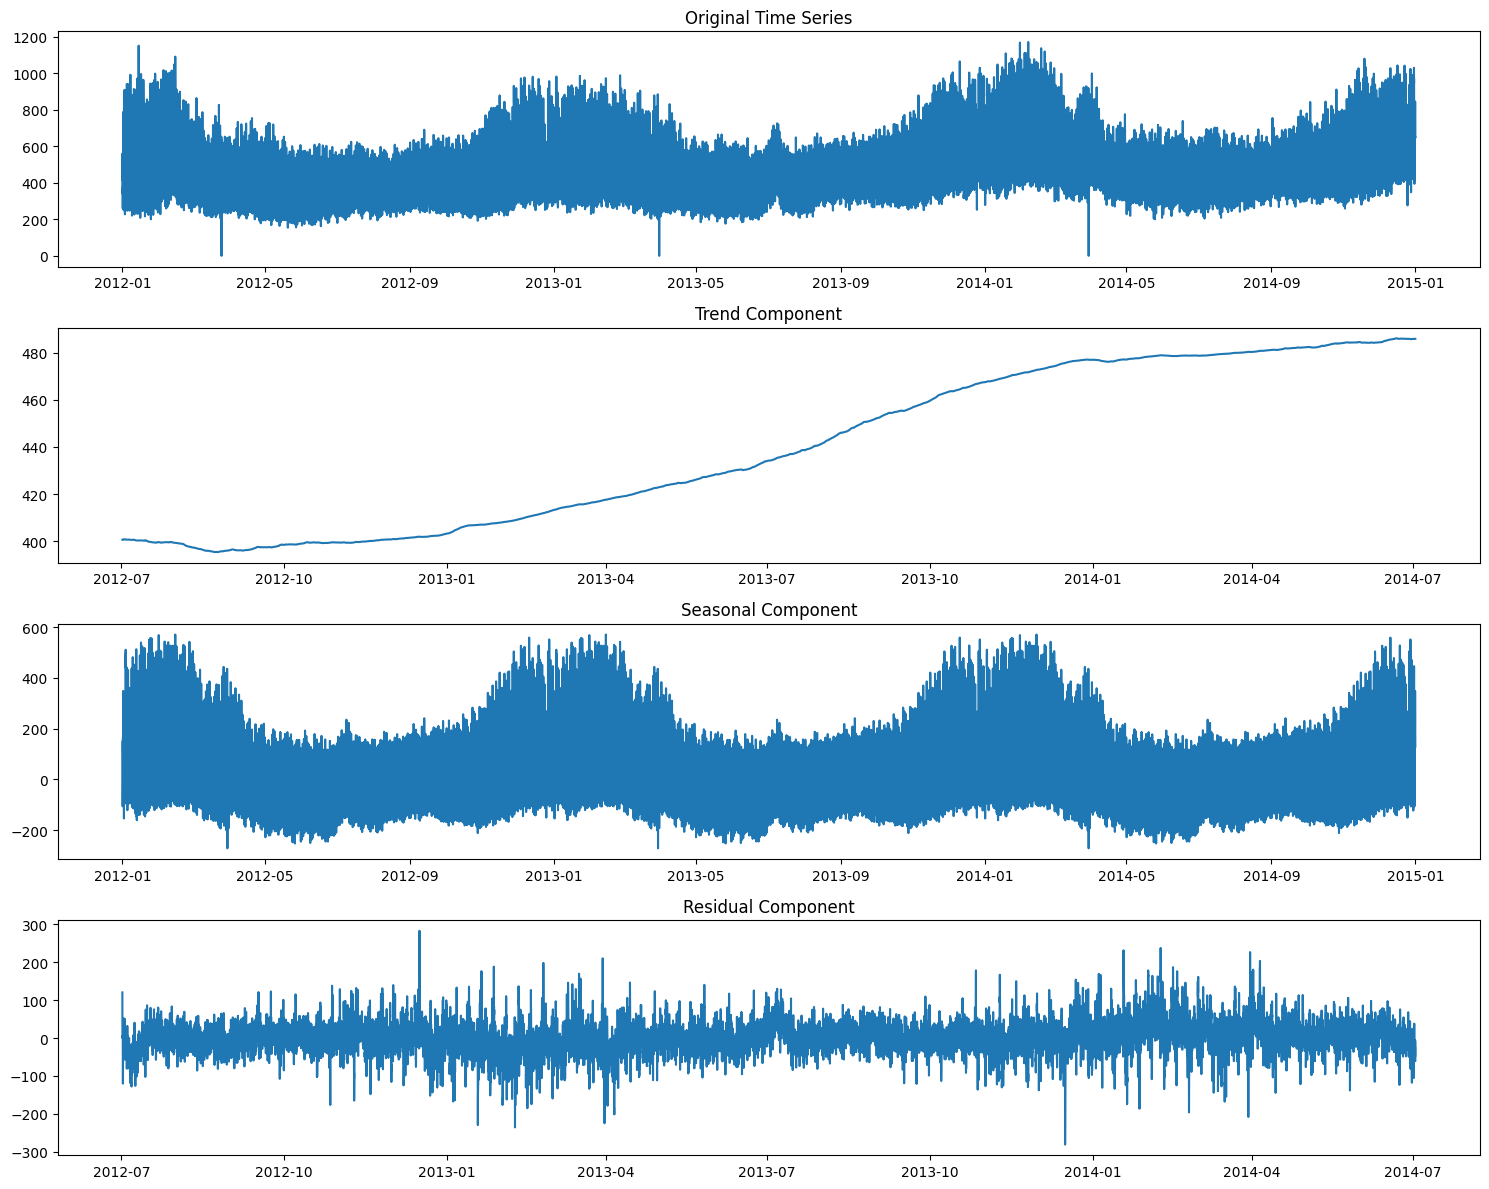

In [10]:
# Decompose the time series into trend and seasonality components

# Perform seasonal decomposition (yearly seasonality - see period arg)
decomposition = seasonal_decompose(single_series, model='additive', period=365*24)
# Plot the components
fig, ax = plt.subplots(4, 1, figsize=(15, 12))
ax[0].plot(single_series, label='Original')
ax[0].set_title('Original Time Series')
ax[1].plot(decomposition.trend, label='Trend')
ax[1].set_title('Trend Component')
ax[2].plot(decomposition.seasonal, label='Seasonality')
ax[2].set_title('Seasonal Component')
ax[3].plot(decomposition.resid, label='Residuals')
ax[3].set_title('Residual Component')
plt.tight_layout()
plt.show()

## Gramian Angular Field (GAF) Transformation - Theory

Gramian Angular Fields (GAFs) are a type of image representation that encode temporal dependencies in time series data. GAFs project time series points into a polar coordinate system, where the value is encoded in the angular cosine while the radius corresponds to the time index of each point. This transformation not only preserves temporal dependencies but also creates a unique image for each time series. The encoding steps are as follows:


**1. Rescaling:** Normalizing a time series $X = \left\{x_1,x_2, \dots, x_n\right\}$ to the interval $[-1,1]$ by applying mean normalization:

$$
\tilde{x}_i = \frac{\left(x_i - max(X)\right)+\left(x_i - min(X)\right)}{max(X) - min(X)}.
$$

**2. Representing in polar coordinates:** Compute the polar coordinates of the scaled time series by computing angular cosine:

$$
        \begin{cases}
        \phi=\arccos \left(\tilde{x}_i\right), & -1 \leq \tilde{x}_i \leq 1, \; \tilde{x}_i \in \tilde{X}\\
        r=\frac{t_i}{N}, & t_i \in \mathbb{N}
        \end{cases}
$$

**3. Calculate Gramian Angular Matrices:** Consider the pairwise trigonometric sum/difference of each point in the time series data to identify temporal correlations within different time intervals.

$$
        GASF = [\cos(\phi_i + \phi_j)] = \left[\begin{array}{cccc} \cos(\phi_1 + \phi_1) & \cos(\phi_1 + \phi_2) & \cdots & \cos(\phi_1 + \phi_n) \\ 
        \cos(\phi_2 + \phi_1) & \cos(\phi_2 + \phi_2) & \cdots & \cos(\phi_2 + \phi_n) \\
        \cdots & \cdots & \cdots & \cdots \\
        \cos(\phi_n + \phi_1) & \cos(\phi_n + \phi_2) & \cdots & \cos(\phi_n + \phi_n) \end{array}\right],
$$

$$
GADF = [\sin(\phi_i - \phi_j)].
$$

Observe that the time dimensionality is encoded into the geometry of the Gram Matrix as the position moves from top-left to bottom-right. Additionally, the transformation is bijective as $\cos(\phi)$ is monotonic when $\phi \in [0,\pi]$. This not only explains the uniqueness of the obtained image but also allows for the reconstruction of the original time series from the main diagonal entries of the GAFs.

## Testing GAF Transform on Full Series

_Note: Applying the GAF transform on the full time series is computationally expensive, and takes time to load. To keep in mind to assess feasibility when applying transforms on data windows._

In [ ]:
# Create a GAF transformer
gasf = GramianAngularField(method='summation')
# Apply the GAF transformation to the time series data (COMMENT THIS IF USING np.load!)
# gasf_data = gasf.fit_transform(single_series.to_numpy().reshape(1, -1))

# Loading pre-transformed saved data
gasf_data = np.load('gasf_data.npy')

In [ ]:
print(gasf_data.shape)

In [ ]:
# Visualize the GASF image
plt.figure(figsize=(10, 10))
plt.imshow(gasf_data[0], cmap='rainbow', origin='lower')
plt.title('Gramian Angular Field (GAF) Image')
plt.colorbar()
plt.show()

In [ ]:
# Using a Gramian Angular Difference Field
gadf = GramianAngularField(method='difference')
# gadf_data = gadf.fit_transform(single_series.to_numpy().reshape(1, -1))

# Loading pre-transformed saved data
gadf_data = np.load('gadf_data.npy')

In [ ]:
# GADF Visualization
plt.figure(figsize=(10, 10))
plt.imshow(gadf_data[0], cmap='rainbow', origin='lower')
plt.title('Gramian Angular Field (GAF) Image')
plt.colorbar()
plt.show()

Run the next cell only **once** to save the results of the transformation to local folder, since the GASF/GADF appear to be computationally expensive operations.

In [ ]:
# Saving results of GASF and GADF transform
# np.save('gasf_data.npy', gasf_data)
# np.save('gadf_data.npy', gadf_data)

## Split the Dataset

In [11]:
# 80-20 split for training-validation
split_time = int(len(series) * 0.8)

# Get the training and validation set 
time_train = time[:split_time]
series_train = series[:split_time]
time_valid = time[split_time:]
series_valid = series[split_time:]

## Prepare Features and Labels

We need to prepare the time series data into features and labels for training our model. This is mainly achieved by performing a _windowing_ operation - we group consecutive measurement values into one feature, and the next measurement will be the label.

In [12]:
# Parameters
window_size = 24*7 #  model will use the past week's worth of data (24 hours*7 days = 168) to make predictions.
batch_size = 32
shuffle_buffer_size = 1000
stride = 1 # number of skips used as the sampling window slides across the entire dataset.

_Note: To inspect and compare the windowed dataset to the original time series, disable/comment the shuffle window code line._

In [105]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, stride):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size (number of time windows that are processed in each iteration of training)
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size (note stride argument)
    dataset = dataset.window(window_size + 1, shift=stride, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    #dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [106]:
dataset_windowed = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size, stride)

## Deeper Look at Windowed Dataset

In [107]:
# Print properties of a single batch
print("Properties of a single batch:")
print("------------------------------")
for windows in dataset_windowed.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}') # (batch_size, window_size)
  print(f'shape of second element: {windows[1].shape}') # (batch_size, )

Properties of a single batch:
------------------------------
data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 168)
shape of second element: (32,)


In [108]:
total_elements = 0
for _ in dataset_windowed:
    total_elements += 1
print("Total elements in the dataset:", total_elements)

Total elements in the dataset: 28


In [109]:
def get_window_samples(dataset, num_samples):
    # Helper function to retrieve a specified number of window samples from the dataset
    window_samples = []
    for features, label in dataset.unbatch().take(num_samples):
        window_samples.append((features.numpy(), label.numpy()))
    return window_samples

In [110]:
num_samples = 3
window_samples = get_window_samples(dataset_windowed, num_samples)

for i, (features, label) in enumerate(window_samples):
    print(f"Window {i + 1}:")
    print("Features:")
    print(features)
    print("Label:")
    print(label)
    print("\n")

Window 1:
Features:
[415. 556. 560. 443. 346. 340. 376. 361. 259. 402. 446. 551. 532. 364.
 294. 298. 358. 419. 584. 722. 788. 766. 684. 576. 462. 402. 376. 298.
 253. 249. 354. 450. 410. 430. 410. 492. 556. 438. 434. 400. 406. 566.
 791. 908. 880. 866. 800. 703. 551. 430. 376. 257. 233. 227. 330. 460.
 430. 400. 376. 418. 376. 404. 366. 334. 368. 477. 760. 898. 898. 904.
 882. 691. 503. 426. 388. 298. 258. 266. 338. 440. 472. 432. 330. 378.
 404. 334. 350. 372. 374. 518. 851. 940. 906. 832. 727. 608. 510. 436.
 390. 280. 247. 253. 348. 471. 469. 525. 436. 390. 416. 414. 364. 316.
 338. 443. 795. 940. 793. 789. 722. 650. 517. 462. 386. 292. 252. 274.
 352. 448. 460. 420. 348. 314. 468. 350. 314. 328. 336. 498. 708. 836.
 930. 824. 746. 594. 527. 446. 392. 270. 247. 249. 326. 408. 449. 481.
 519. 555. 549. 481. 464. 518. 510. 636. 858. 991. 884. 742. 678. 632.]
Label:
634.0


Window 2:
Features:
[462. 402. 376. 298. 253. 249. 354. 450. 410. 430. 410. 492. 556. 438.
 434. 400. 406. 566. 

In [111]:
# Original Training Data for Reference
print(series_train)

[415. 556. 560. ... 356. 386. 440.]


In [20]:
print(len(series_train))

21043


## Test Window Generator for GAF

Now that we have a working function for generating data windows on our training data/time series, we need a similar function for generating GAF-transformed data windows.

In [112]:
def windowed_GAF_generator(series, window_size, batch_size, shuffle_buffer, stride):
    # Testing window function with generator
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=stride, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    gasf = GramianAngularField(method='summation')
    
    for window in dataset:
        window = window.numpy()
        gaf_transformed = gasf.fit_transform(window[:-1].reshape(1, -1))
        yield gaf_transformed, window[-1] # return a generator object

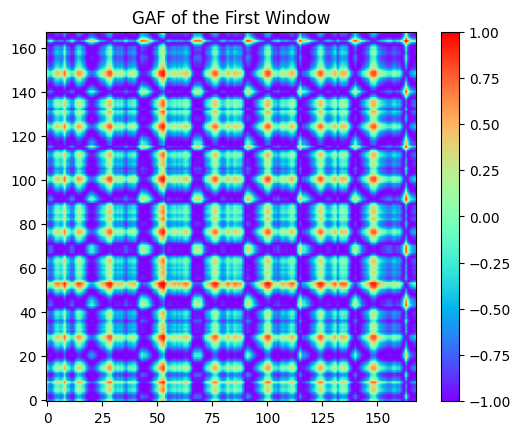

First Window Shape:
(1, 168, 168)
Label:
634.0


In [113]:
window_generator = windowed_GAF_generator(series_train, window_size, batch_size, shuffle_buffer_size, stride)
first_window_gaf, first_window_label = next(window_generator)

plt.imshow(first_window_gaf[0], cmap='rainbow', origin='lower')
plt.colorbar()
plt.title("GAF of the First Window")
plt.show()

print("First Window Shape:")
print(first_window_gaf.shape) # check dimensions of GAF window

print("Label:")
print(first_window_label)

In [114]:
print(first_window_gaf[0].shape)

(168, 168)


## Mean Normalization on Labels

The GAF transform performs the mean normalization within the built in function. We will need to apply mean normalization of the labels as well for the training to be consistent. The mean normalization will need to be performed relative to each window of time series data. 

Here, we update the `windowed_GAF_generator` function for mean normalization on our labels.

In [115]:
def windowed_GAF_generator(series, window_size, batch_size, shuffle_buffer, stride):
    
    # Testing window function with generator (UPDATED FOR MEAN NORMALIZATION)
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=stride, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    gasf = GramianAngularField(method='summation')
    
    for window in dataset:
        window = window.numpy()
        
        # Calculate min and max of the window
        window_min = np.min(window[:-1])
        window_max = np.max(window[:-1])
        
        # Mean normalize the target (window is automatically mean normalized during GAF transform)
        gaf_transformed = gasf.fit_transform(window[:-1].reshape(1, -1))
        normalized_target = ((window[-1] - window_max) + (window[-1] - window_min)) / (window_max - window_min)
        
        yield gaf_transformed, normalized_target # return a generator object

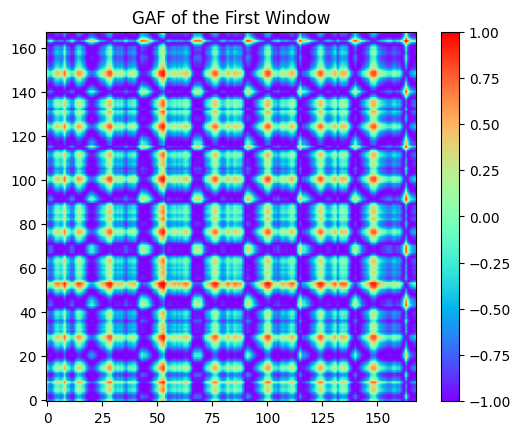

First Window Shape:
(1, 168, 168)
Label:
0.06544502617801047


In [116]:
window_generator = windowed_GAF_generator(series_train, window_size, batch_size, shuffle_buffer_size, stride)
first_window_gaf, first_window_label = next(window_generator)

plt.imshow(first_window_gaf[0], cmap='rainbow', origin='lower')
plt.colorbar()
plt.title("GAF of the First Window")
plt.show()

print("First Window Shape:")
print(first_window_gaf.shape) # check dimensions of GAF window

print("Label:")
print(first_window_label)

## Data Preprocessing by Gramian Angular Fields (GAFs)

The peviously defined `windowed_GAF_generator` are generator functions. Now that we have verified it works, we update it further to include capture groups for all GAF-transformed windows and normalized targets. 

In [50]:
def windowed_GAF_generator(series, window_size, stride):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=stride, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    gasf = GramianAngularField(method='summation')
    
    gaf_outputs = []
    targets = []
    for window in dataset:
        window = window.numpy()
        
        # Calculate min and max of the window
        window_min = np.min(window[:-1])
        window_max = np.max(window[:-1])
        
        gaf_transformed = gasf.fit_transform(window[:-1].reshape(1, -1))
        gaf_outputs.append(tf.convert_to_tensor(gaf_transformed[0]))
        
        # Mean normalize the target
        normalized_target = ((window[-1] - window_max) + (window[-1] - window_min)) / (window_max - window_min)
        targets.append(tf.convert_to_tensor(normalized_target))

    return gaf_outputs, targets

In [53]:
stride = 24 # We use a stride of one day (24 hours) for more efficient training.
gaf_outputs, targets = windowed_GAF_generator(series, window_size, stride)
gaf_dataset = tf.data.Dataset.from_tensor_slices((gaf_outputs, targets))

## Inspecting GAF Data Processing Pipeline (Verification)

Now that we have inspected the outputs which seem to be appropriate, we can apply batching and shuffling of the dataset prior to training.

In [54]:
print(gaf_dataset.element_spec)

(TensorSpec(shape=(168, 168), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))


In [55]:
for windows in gaf_dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (168, 168)
shape of second element: ()


In [56]:
total_elements = 0
for _ in gaf_dataset:
    total_elements += 1
print("Total elements in the dataset:", total_elements)

Total elements in the dataset: 1089


In [57]:
# Extract the first GAF-transformed window and target value
first_gaf_window, first_target = next(iter(gaf_dataset))

# Convert the tensors to numpy arrays
first_gaf_window_np = first_gaf_window.numpy()
first_target_np = first_target.numpy()

print("First GAF-transformed window:")
print(first_gaf_window)
print("\nFirst target value:", first_target_np)

First GAF-transformed window:
tf.Tensor(
[[-0.48416984 -0.7826506  -0.78918362 ... -0.98436306 -0.93900668
  -0.89045821]
 [-0.7826506  -0.96150051 -0.96435031 ... -0.97667178 -0.99909987
  -0.99688533]
 [-0.78918362 -0.96435031 -0.96709246 ... -0.97434842 -0.99859591
  -0.99766295]
 ...
 [-0.98436306 -0.97667178 -0.97434842 ... -0.75755873 -0.85912401
  -0.91476864]
 [-0.93900668 -0.99909987 -0.99859591 ... -0.85912401 -0.93474685
  -0.97089152]
 [-0.89045821 -0.99688533 -0.99766295 ... -0.91476864 -0.97089152
  -0.99274965]], shape=(168, 168), dtype=float64)

First target value: 0.06544502617801047


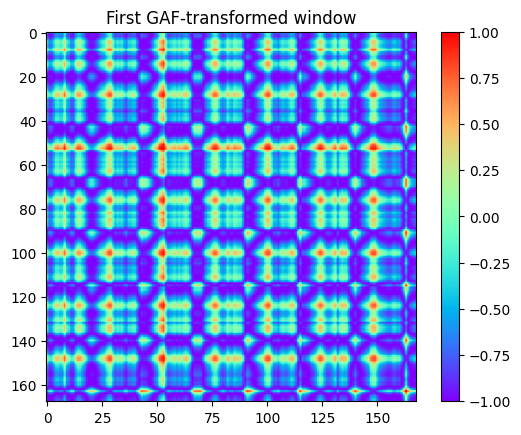

In [58]:
import matplotlib.pyplot as plt

plt.imshow(first_gaf_window_np, cmap='rainbow')
plt.colorbar()
plt.title("First GAF-transformed window")
plt.show()

In [59]:
# Apply batching on the GAF dataset
gaf_dataset = gaf_dataset.batch(batch_size).prefetch(1)

In [60]:
# Shuffle the dataset
gaf_dataset = gaf_dataset.shuffle(shuffle_buffer_size)

In [61]:
total_elements = 0
for _ in gaf_dataset:
    total_elements += 1
print("Total elements in the dataset:", total_elements)

Total elements in the dataset: 35


In [62]:
# Print properties of a single batch
print("Properties of a single batch:")
print("------------------------------")
for windows in gaf_dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}') # (batch_size, window_size)
  print(f'shape of second element: {windows[1].shape}') # (batch_size, )

Properties of a single batch:
------------------------------
data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 168, 168)
shape of second element: (32,)


## Implementation of Skip-GRU Layer:

**Update:** Include fix for Type Inference error-warning message.
```
def call(self, inputs):
    ...
    for t in tf.range(self.timesteps, dtype=tf.int32):  # Add dtype=tf.int32
        ...
```

In [21]:
class SkipGRU(tf.keras.layers.Layer):

    def __init__(self,
                 units,
                 p=1,
                 activation='relu',
                 return_sequences=False,
                 return_state=False,
                 **kwargs):

        '''
        Recurrent-skip layer, see Section 3.4 in the LSTNet paper.
        
        Parameters:
        __________________________________
        units: int.
            Number of hidden units of the GRU cell.

        p: int.
            Number of skipped hidden cells.

        activation: str, function.
            Activation function, see https://www.tensorflow.org/api_docs/python/tf/keras/activations.

        return_sequences: bool.
            Whether to return the last output or the full sequence.

        return_state: bool.
            Whether to return the last state in addition to the output.

        **kwargs: See https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRUCell.
        '''

        if p < 1:
            raise ValueError('The number of skipped hidden cells cannot be less than 1.')

        self.units = units
        self.p = p
        self.return_sequences = return_sequences
        self.return_state = return_state
        self.timesteps = None
        self.cell = tf.keras.layers.GRUCell(units=units, activation=activation, **kwargs)

        super(SkipGRU, self).__init__()

    def build(self, input_shape):

        if self.timesteps is None:
            self.timesteps = input_shape[1]

            if self.p > self.timesteps:
                raise ValueError('The number of skipped hidden cells cannot be greater than the number of timesteps.')

    def call(self, inputs):

        '''
        Parameters:
        __________________________________
        inputs: tf.Tensor.
            Layer inputs, 2-dimensional tensor with shape (n_samples, filters) where n_samples is the batch size
            and filters is the number of channels of the convolutional layer.

        Returns:
        __________________________________
        outputs: tf.Tensor.
            Layer outputs, 2-dimensional tensor with shape (n_samples, units) if return_sequences == False,
            3-dimensional tensor with shape (n_samples, n_lookback, units) if return_sequences == True where
            n_samples is the batch size, n_lookback is the number of past time steps used as input and units
            is the number of hidden units of the GRU cell.

        states: tf.Tensor.
            Hidden states, 2-dimensional tensor with shape (n_samples, units) where n_samples is the batch size
            and units is the number of hidden units of the GRU cell.
        '''

        outputs = tf.TensorArray(
            element_shape=(inputs.shape[0], self.units),
            size=self.timesteps,
            dynamic_size=False,
            dtype=tf.float32,
            clear_after_read=False
        )

        states = tf.TensorArray(
            element_shape=(inputs.shape[0], self.units),
            size=self.timesteps,
            dynamic_size=False,
            dtype=tf.float32,
            clear_after_read=False
        )

        initial_states = tf.zeros(
            shape=(tf.shape(inputs)[0], self.units),
            dtype=tf.float32
        )

        for t in tf.range(self.timesteps, dtype=tf.int32):

            if t < self.p:
                output, state = self.cell(
                    inputs=inputs[:, t, :],
                    states=initial_states
                )

            else:
                output, state = self.cell(
                    inputs=inputs[:, t, :],
                    states=states.read(t - self.p)
                )

            outputs = outputs.write(index=t, value=output)
            states = states.write(index=t, value=state)

        outputs = tf.transpose(outputs.stack(), [1, 0, 2])
        states = tf.transpose(states.stack(), [1, 0, 2])

        if not self.return_sequences:
            outputs = outputs[:, -1, :]

        if self.return_state:
            states = states[:, -1, :]
            return outputs, states

        else:
            return outputs

## Kernal Regularizer
Regularization helper function for controlling against overfitting.

In [22]:
def kernel_regularizer(regularizer, regularization_factor):

    '''
    Parameters:
    __________________________________
    regularizer: str.
        Regularizer, either 'L1', 'L2' or 'L1L2'.

    regularization_factor: float.
        Regularization factor.
    '''
    
    if regularizer == 'L1':
        return tf.keras.regularizers.L1(l1=regularization_factor)

    elif regularizer == 'L2':
        return tf.keras.regularizers.L2(l2=regularization_factor)

    elif regularizer == 'L1L2':
        return tf.keras.regularizers.L1L2(l1=regularization_factor, l2=regularization_factor)

    else:
        raise ValueError('Undefined regularizer {}.'.format(regularizer))

## LSTNet Main Model Architecture:
* Modified model to include the Attention Mechanism, to use, specify `num_heads` argument. 
* Further modified model to include toggle on the use of Attention Mechanism, see `use_attention` parameter.


In [24]:
def build_fn(n_targets, # Number of time series. (int)
             n_lookback, # Number of past time steps to use as input. (int)
             filters, # Number of filters (or channels) of the convolutional layer. (int)
             kernel_size, # Kernel size of the convolutional layer. (int)
             gru_units, # Hidden units of GRU layer. (list)
             skip_gru_units, # Hidden units of Skip GRU layer. (list)
             skip, # Number of skipped hidden cells in the Skip GRU layer. (int)
             lags, # Number of autoregressive lags. (int)
             dropout, # Dropout rate. (float)
             regularizer, # Regularizer, either 'L1', 'L2' or 'L1L2'. (str)
             regularization_factor,  # Regularization factor. (float)
             num_heads = 2, # Number of attention heads, default = 2. (int)
             use_attention = True): # Toggle use of Attention Mechanism. (bool)

    # Inputs.
    x = tf.keras.layers.Input(shape=(n_lookback, n_targets))

    # Convolutional component, see Section 3.2 in the LSTNet paper.
    c = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(x)
    c = tf.keras.layers.Dropout(rate=dropout)(c)

    # Recurrent component, see Section 3.3 in the LSTNet paper.
    r = tf.keras.layers.GRU(units=gru_units, activation='relu', return_sequences=use_attention)(c)
    
    # Attention Mechanism, see Section 3.5 in the LSTNet paper.
    if use_attention:
        r = MultiHeadAttention(num_heads=num_heads, key_dim=gru_units)(r, r)
        r = tf.keras.layers.Flatten()(r)

    r = tf.keras.layers.Dropout(rate=dropout)(r)
    
    # Recurrent-skip component, see Section 3.4 in the LSTNet paper.
    s = SkipGRU(units=skip_gru_units, activation='relu', return_sequences=True)(c)
    s = tf.keras.layers.Dropout(rate=dropout)(s)
    s = tf.keras.layers.Lambda(function=lambda x: x[:, - skip:, :])(s)
    s = tf.keras.layers.Reshape(target_shape=(s.shape[1] * s.shape[2],))(s)
    d = tf.keras.layers.Concatenate(axis=1)([r, s])
    d = tf.keras.layers.Dense(units=n_targets, kernel_regularizer=kernel_regularizer(regularizer, regularization_factor))(d)

    # Autoregressive component, see Section 3.6 in the LSTNet paper.
    l = tf.keras.layers.Flatten()(x[:, - lags:, :])
    l = tf.keras.layers.Dense(units=n_targets, kernel_regularizer=kernel_regularizer(regularizer, regularization_factor))(l)

    # Outputs.
    y = tf.keras.layers.Add()([d, l])

    return tf.keras.models.Model(x, y)

In [28]:
# Build and save LSTNet Model (SET MODEL PARAMETERS HERE)
model = build_fn(
    n_targets = 1, # univariate time series test
    n_lookback = window_size,
    filters = 64,
    kernel_size = 3,
    gru_units = 100,
    skip_gru_units = 50,
    skip = 1,
    lags = 1,
    dropout = 0,
    regularizer = 'L2',
    regularization_factor = 0.01,
    num_heads = 2,
    use_attention = False)

In [29]:
 # Print the model summary 
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 168, 1)]     0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 166, 64)      256         ['input_2[0][0]']                
                                                                                                  
 dropout_3 (Dropout)            (None, 166, 64)      0           ['conv1d_1[0][0]']               
                                                                                                  
 skip_gru_1 (SkipGRU)           (None, 166, 50)      17400       ['dropout_3[0][0]']              
                                                                                            

## Model Training (Modified Training Pipeline)

In [31]:
def train_and_load_history(model, dataset_windowed, model_history_path, model_weights_path, epochs):
    
    # HYPERPARAMETERS FOR TRAINING
    # ----------------------------
    # Set the learning rate
    learning_rate = 7.0795e-06 # optimal from one round of Hyperparameter tuning

    # Set the optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    # Set the training parameters
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    
    # ---------------------------- 

    if os.path.exists(model_history_path) and os.path.exists(model_weights_path):
        print("Loading existing history and model weights...")
        with open(model_history_path, 'rb') as f:
            loaded_history = pickle.load(f)
        model.load_weights(model_weights_path)
    else:
        print("Training the model...")
        history = model.fit(dataset_windowed, epochs=epochs)
        loaded_history = history.history
        with open(model_history_path, 'wb') as f:
            pickle.dump(loaded_history, f)
        model.save_weights(model_weights_path)
    
    return loaded_history

In [42]:
# Set number of epochs to run, train the model or load existing model (if .pkl and .h5 file exist in directory)
epochs = 5
model_history_path = "model_history.pkl"
model_weights_path = "model_weights.h5"

loaded_history = train_and_load_history(model, dataset_windowed, model_history_path, model_weights_path, epochs)

# Get mae and loss from loaded_history
mae = loaded_history['mae']
loss = loaded_history['loss']

Loading existing history and model weights...


## Visualize MAE and Loss

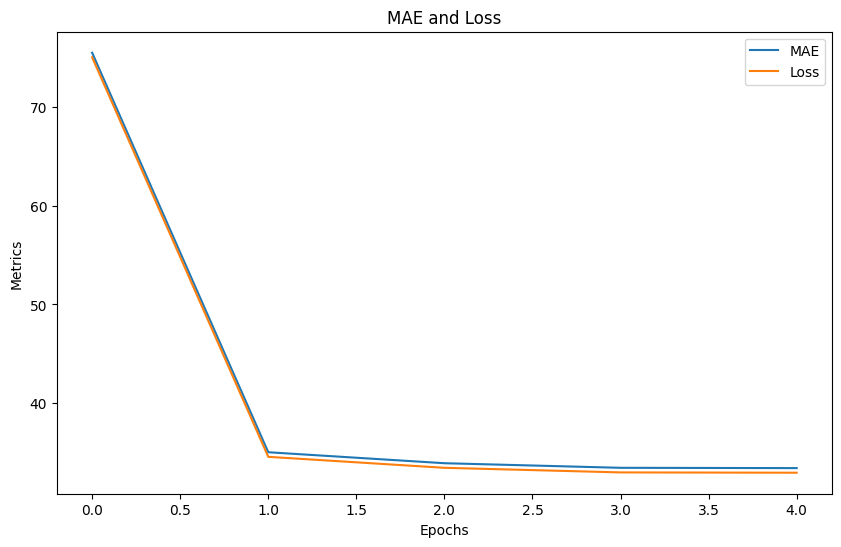

In [43]:
# Get number of epochs
epochs = range(len(loss))

# Plot mae and loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, label='MAE')
plt.plot(epochs, loss, label='Loss')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

## Model Prediction (One-step forecasting)

In [35]:
def model_forecast(model, series, window_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """
    
    # Generate TF Dataset from series values
    ds = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    
    # Flatten windows by putting elements in a single batch
    ds = ds.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    ds = ds.batch(32).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(ds)
    
    return forecast

In [36]:
# Compute the forecast for all the series
forecast = model_forecast(model, series, window_size).squeeze()
# Slice the forecast to get only the predictions for the validation set
forecast = forecast[split_time - window_size:-1]

817/817 [==============================] - 26s 31ms/step


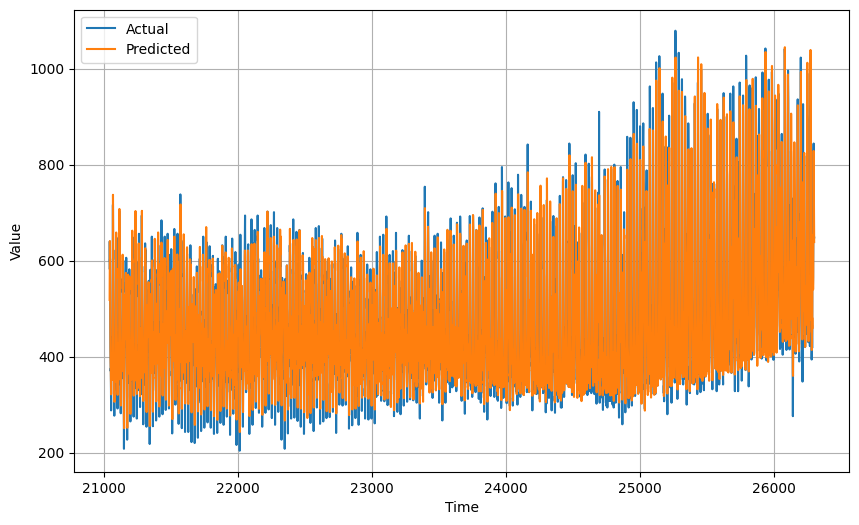

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(time_valid, series_valid, label="Actual")
plt.plot(time_valid, forecast, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

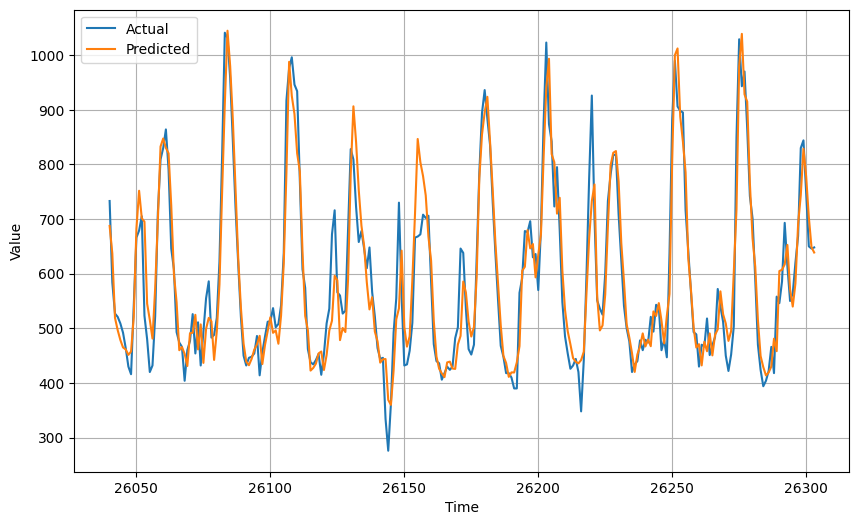

In [38]:
# ZOOMING INTO LAST 5% OF DATA POINTS
zoom_start_idx = int(0.95 * len(time_valid))

zoom_time_valid = time_valid[zoom_start_idx:]
zoom_series_valid = series_valid[zoom_start_idx:]
zoom_forecast = forecast[zoom_start_idx:]

plt.figure(figsize=(10, 6))
plt.plot(zoom_time_valid, zoom_series_valid, label="Actual")
plt.plot(zoom_time_valid, zoom_forecast, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

## Forecasting Evaluation

Comparing against the naive forecast (predicting value at the next time step to be the same as the value at the current time step)

In [39]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [40]:
# Generate naive forecast
naive_forecast = series_valid[:-1]

# Compute metrics for naive forecast
mse_naive, mae_naive = compute_metrics(series_valid[1:], naive_forecast)

print("Naive Forecast - Mean Squared Error (MSE):", mse_naive)
print("Naive Forecast - Mean Absolute Error (MAE):", mae_naive)

Naive Forecast - Mean Squared Error (MSE): 4951.533460076045
Naive Forecast - Mean Absolute Error (MAE): 51.24942965779468


In [41]:
mse, mae = compute_metrics(series_valid, forecast)
print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 1919.96, mae: 32.69 for forecast


## Additional Evaluation Metrics (RSE and Corr)

- Root Relative Squared Error (RSE):
$$
R S E=\frac{\sqrt{\sum_{(i, t) \in \Omega_{T e s t}}\left(Y_{i t}-\hat{Y}_{i t}\right)^2}}{\sqrt{\sum_{(i, t) \in \Omega_{T e s t}}\left(Y_{i t}-\operatorname{mean}(Y)\right)^2}}
$$
- Empirical Correlation Coefficient (CORR)
$$
C O R R=\frac{1}{n} \sum_{i=1}^n \frac{\sum_t\left(Y_{i t}-\operatorname{mean}\left(Y_i\right)\right)\left(\hat{Y}_{i t}-\operatorname{mean}\left(\hat{Y}_i\right)\right)}{\sqrt{\sum_t\left(Y_{i t}-\operatorname{mean}\left(Y_i\right)\right)^2\left(\hat{Y}_{i t}-\operatorname{mean}\left(\hat{Y}_i\right)\right)^2}}
$$

For RSE lower value is better, while for CORR higher value is better.

In [45]:
def compute_rse(true_series, forecast):
    rse_numerator = np.sqrt(np.sum(np.square(true_series - forecast)))
    rse_denominator = np.sqrt(np.sum(np.square(true_series - np.mean(true_series))))
    rse = rse_numerator / rse_denominator
    return rse

In [46]:
def compute_corr(true_series, forecast):
    # Reshape the data if it's a single time series (1D)
    if len(true_series.shape) == 1:
        true_series = true_series.reshape(1, -1)
        forecast = forecast.reshape(1, -1)

    n = true_series.shape[0]
    corrs = []

    for i in range(n):
        y_true_i = true_series[i]
        y_pred_i = forecast[i]
        corr = np.corrcoef(y_true_i, y_pred_i)[0, 1]
        corrs.append(corr)

    # Calculate the average correlation across all time series
    return np.mean(corrs)

In [47]:
rse = compute_rse(series_valid, forecast)
print(f"Relative Squared Error (RSE): {rse:.2f}")

corr = compute_corr(series_valid, forecast)
print(f"Correlation: {corr:.2f}")

Relative Squared Error (RSE): 0.32
Correlation: 0.95


## Modifying LSTNet Architecture for GAF Input

Note that we modify the Input layer to accept the GAF 2D tensor as the input, and the Covolutional Component to perform deeper feature extraction and dimensionality reduction (with MaxPooling), before reshaping as an appropriate sequential input to the Recurrent Components.

In [117]:
def build_fn(n_targets, # Number of time series. (int)
             n_lookback, # Number of past time steps to use as input. (int)
             filters, # Number of filters (or channels) of the convolutional layer. (int)
             kernel_size, # Kernel size of the convolutional layer. (int)
             gru_units, # Hidden units of GRU layer. (list)
             skip_gru_units, # Hidden units of Skip GRU layer. (list)
             skip, # Number of skipped hidden cells in the Skip GRU layer. (int)
             lags, # Number of autoregressive lags. (int)
             dropout, # Dropout rate. (float)
             regularizer, # Regularizer, either 'L1', 'L2' or 'L1L2'. (str)
             regularization_factor,  # Regularization factor. (float)
             num_heads = 2, # Number of attention heads, default = 2. (int)
             use_attention = True): # Toggle use of Attention Mechanism. (bool)

    # Inputs (Modified)
    x = tf.keras.layers.Input(shape=(n_lookback,n_lookback,n_targets))

    # Convolutional component, see Section 3.2 in the LSTNet paper.
    c = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu')(x)
    c = tf.keras.layers.MaxPooling2D(2, 2)(c)
    c = tf.keras.layers.Dropout(rate=dropout)(c)
    c = tf.keras.layers.Reshape((-1, c.shape[1] * c.shape[2] * c.shape[3]))(c)

    # Recurrent component, see Section 3.3 in the LSTNet paper.
    r = tf.keras.layers.GRU(units=gru_units, activation='relu', return_sequences=use_attention)(c)
    
    # Attention Mechanism, see Section 3.5 in the LSTNet paper.
    if use_attention:
        r = MultiHeadAttention(num_heads=num_heads, key_dim=gru_units)(r, r)
        r = tf.keras.layers.Flatten()(r)

    r = tf.keras.layers.Dropout(rate=dropout)(r)
    
    # Recurrent-skip component, see Section 3.4 in the LSTNet paper.
    s = SkipGRU(units=skip_gru_units, activation='relu', return_sequences=True)(c)
    s = tf.keras.layers.Dropout(rate=dropout)(s)
    s = tf.keras.layers.Lambda(function=lambda x: x[:, - skip:, :])(s)
    s = tf.keras.layers.Reshape(target_shape=(s.shape[1] * s.shape[2],))(s)
    d = tf.keras.layers.Concatenate(axis=1)([r, s])
    d = tf.keras.layers.Dense(units=n_targets, kernel_regularizer=kernel_regularizer(regularizer, regularization_factor))(d)

    # Autoregressive component, see Section 3.6 in the LSTNet paper.
    l = tf.keras.layers.Flatten()(x[:, - lags:, :])
    l = tf.keras.layers.Dense(units=n_targets, kernel_regularizer=kernel_regularizer(regularizer, regularization_factor))(l)

    # Outputs.
    y = tf.keras.layers.Add()([d, l])

    return tf.keras.models.Model(x, y)

## Initialize Modified Model

In [118]:
# Build and save LSTNet Model (SET MODEL PARAMETERS HERE)
model = build_fn(
    n_targets = 1, # univariate time series test
    n_lookback = window_size,
    filters = 64,
    kernel_size = 3,
    gru_units = 100,
    skip_gru_units = 50,
    skip = 1,
    lags = 1,
    dropout = 0,
    regularizer = 'L2',
    regularization_factor = 0.01,
    num_heads = 2,
    use_attention = False)

In [119]:
 # Print the model summary 
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 168, 168, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 166, 166, 64  640         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 83, 83, 64)  0           ['conv2d_1[0][0]']               
                                                                                            

## Modified Model Training

In [120]:
# Set the learning rate
learning_rate = 0.001

# Set the optimizer 
# optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate) # Adam optimizer appears to run quite slowly
#optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)
optimizer = tf.keras.optimizers.Adam(clipnorm=1.0) # apply gradient clipping in case of gradient explosion

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [121]:
# Train the model on GAF dataset
history = model.fit(gaf_dataset,epochs=10)

Epoch 1/10


2023-04-07 18:04:19.738670: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}

	while inferring type of node 'model_5/skip_gru_3/while/body/_184/model_5/skip_gru_3/while/cond/output/_1262'


35/35 [==============================] - 49s 1s/step - loss: 13.9618 - mae: 14.4090
Epoch 2/10
35/35 [==============================] - 46s 1s/step - loss: 0.4155 - mae: 0.7432
Epoch 3/10
35/35 [==============================] - 48s 1s/step - loss: 0.0909 - mae: 0.2538
Epoch 4/10
35/35 [==============================] - 41s 1s/step - loss: 0.0489 - mae: 0.1545
Epoch 5/10
35/35 [==============================] - 44s 1s/step - loss: 0.0400 - mae: 0.1239
Epoch 6/10
35/35 [==============================] - 42s 1s/step - loss: 0.0372 - mae: 0.1207
Epoch 7/10
35/35 [==============================] - 41s 1s/step - loss: 0.0322 - mae: 0.1003
Epoch 8/10
35/35 [==============================] - 43s 1s/step - loss: 0.0319 - mae: 0.1081
Epoch 9/10
35/35 [==============================] - 44s 1s/step - loss: 0.0337 - mae: 0.1255
Epoch 10/10
35/35 [==============================] - 46s 1s/step - loss: 0.0285 - mae: 0.1013


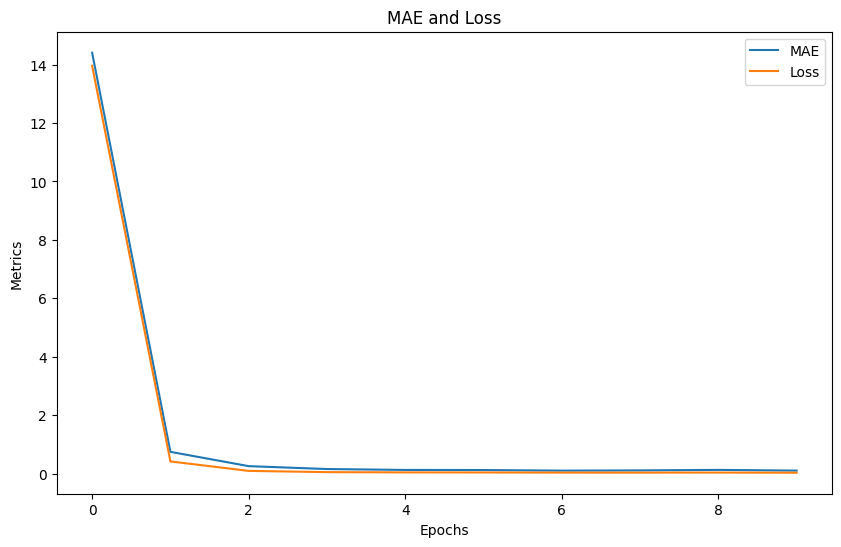

In [122]:
# Get mae and loss from history log
mae = history.history['mae']
loss = history.history['loss']

# Get number of epochs
epochs = range(len(loss))

# Plot mae and loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, label='MAE')
plt.plot(epochs, loss, label='Loss')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

## Modified Model Prediction

Note that we modify the `model_forecast` function to handle the GAF transformed data, as well as performing denormalization on the forecast values (we previously normalized the target).

In [123]:
def model_forecast(model, series, window_size):
    """
    Modified model_forecast function for GAFs.
    """
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    
    # GAF Transformation on each data window
    gasf = GramianAngularField(method='summation')
    gaf_outputs = []
    
    
    window_mins = []
    window_maxs = []
    for window in ds:
        window = window.numpy()
        window_mins.append(np.min(window))
        window_maxs.append(np.max(window))
        gaf_transformed = gasf.fit_transform(window.reshape(1, -1))
        gaf_outputs.append(gaf_transformed[0])

    # Convert GAF outputs to a numpy array
    gaf_outputs = np.array(gaf_outputs)

    # Reshape GAF outputs to 4D (batch_size, height, width, channels)
    gaf_outputs = gaf_outputs.reshape(-1, window_size, window_size, 1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(gaf_outputs)
    
    return forecast, window_mins, window_maxs

In [124]:
forecast, window_mins, window_maxs = model_forecast(model, series, window_size)

817/817 [==============================] - 9797s 12s/step


In [125]:
forecast_denorm = np.zeros_like(forecast)
for i in range(len(forecast)):
    min_val = window_mins[i]
    max_val = window_maxs[i]
    forecast_denorm[i] = forecast[i] * (max_val - min_val) + (max_val + min_val) / 2

In [126]:
# Slice the forecast to get only the predictions for the validation set
forecast = forecast_denorm[split_time - window_size:-1, 0]

## Forecasting Evaluation

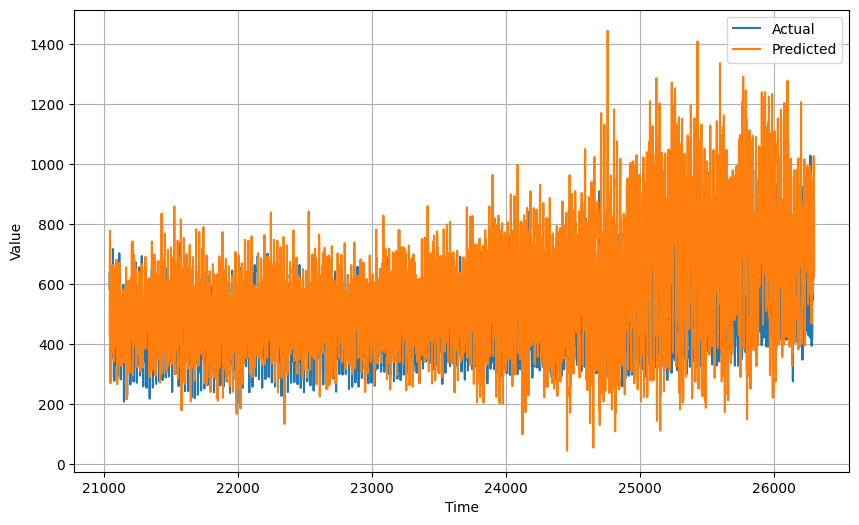

In [127]:
plt.figure(figsize=(10, 6))
plt.plot(time_valid, series_valid, label="Actual")
plt.plot(time_valid, forecast, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

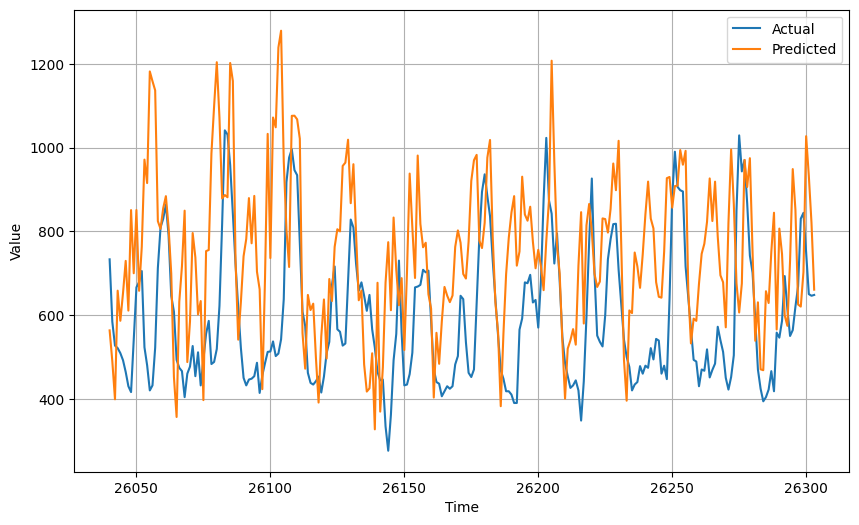

In [128]:
# ZOOMING INTO LAST 5% OF DATA POINTS
zoom_start_idx = int(0.95 * len(time_valid))

zoom_time_valid = time_valid[zoom_start_idx:]
zoom_series_valid = series_valid[zoom_start_idx:]
zoom_forecast = forecast[zoom_start_idx:]

plt.figure(figsize=(10, 6))
plt.plot(zoom_time_valid, zoom_series_valid, label="Actual")
plt.plot(zoom_time_valid, zoom_forecast, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

## Forecasting Evaluation

In [129]:
# Generate naive forecast
naive_forecast = series_valid[:-1]

# Compute metrics for naive forecast
mse_naive, mae_naive = compute_metrics(series_valid[1:], naive_forecast)

print("Naive Forecast - Mean Squared Error (MSE):", mse_naive)
print("Naive Forecast - Mean Absolute Error (MAE):", mae_naive)

Naive Forecast - Mean Squared Error (MSE): 4951.533460076045
Naive Forecast - Mean Absolute Error (MAE): 51.24942965779468


In [130]:
mse, mae = compute_metrics(series_valid, forecast)
print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 44624.12, mae: 156.08 for forecast


In [131]:
mse_list = []
mae_list = []

# Iterate through the validation set
for t in range(len(series_valid)):
    true_series_t = series_valid[:t+1]
    forecast_t = forecast[:t+1]
    
    mse_t, mae_t = compute_metrics(true_series_t, forecast_t)
    
    mse_list.append(mse_t)
    mae_list.append(mae_t)

# Convert lists to numpy arrays
mse_array = np.array(mse_list)
mae_array = np.array(mae_list)

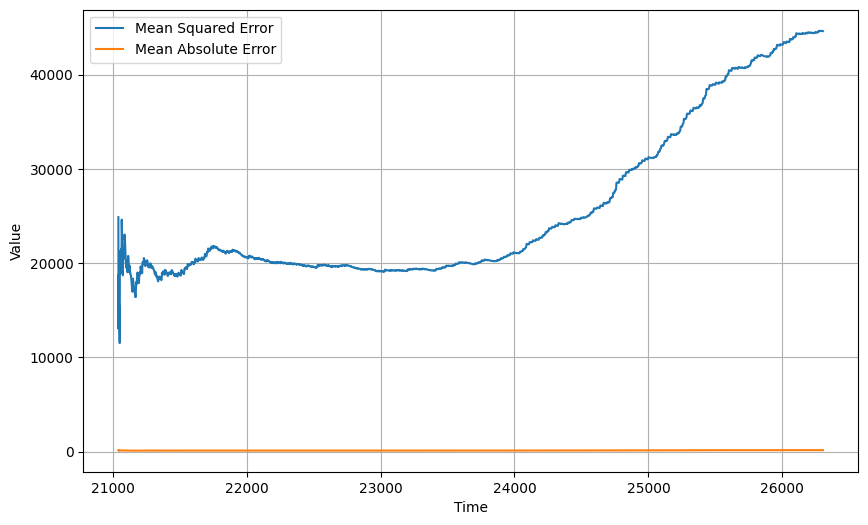

In [132]:
# Plot the MSE and MAE over time
plt.figure(figsize=(10, 6))
plt.plot(time_valid, mse_array, label="Mean Squared Error")
plt.plot(time_valid, mae_array, label="Mean Absolute Error")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

In [82]:
abs_error_list = []
mae_list = []

# Iterate through the validation set
for t in range(len(series_valid)):
    true_series_t = series_valid[:t+1]
    forecast_t = forecast[:t+1]
    
    abs_error_t = np.abs(true_series_t - forecast_t)
    mae_t = np.mean(abs_error_t)
    
    abs_error_list.append(abs_error_t[-1])  # Append the last element in the array
    mae_list.append(mae_t)

# Convert lists to numpy arrays
abs_error_array = np.array(abs_error_list)
mae_array = np.array(mae_list)

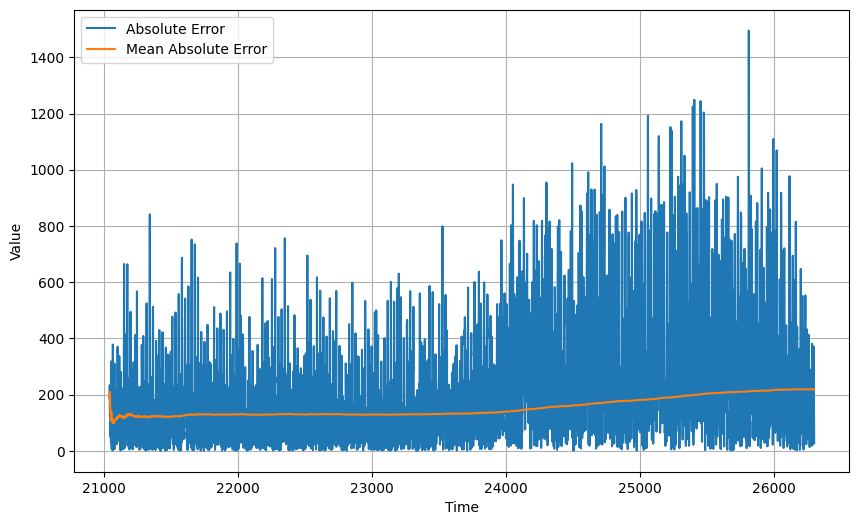

In [83]:
# Plot the Absolute Error and Mean Absolute Error over time
plt.figure(figsize=(10, 6))
plt.plot(time_valid, abs_error_array, label="Absolute Error")
plt.plot(time_valid, mae_array, label="Mean Absolute Error")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

## Adjusting the Model

The initial approach of just changing the convolution component to a 2D-CNN and then flattening it to allow for it to input into the RNN layer appears to yield a poor performance. 

**Hypothesis:** Performing the layer flattening operation with the following code line

```
c = tf.keras.layers.Reshape((-1, c.shape[1] * c.shape[2] * c.shape[3]))(c)
```

appears to be causing a loss/destruction in the spatial information of the learnt GAF features. We need an alternative approach that preserves the spatial information from the GAF images while still feeding the data into the recurrent component. 

**As such, in this section, we consider the use of ConvLSTM layers instead of the combination of Conv2D and LSTM layers.|**

In [90]:
def build_model(n_lookback, n_targets, filters, kernel_size, lstm_units, dropout):
    # Inputs
    x = tf.keras.layers.Input(shape=(n_lookback, n_lookback, n_targets))

    # Add a time dimension to the input
    x_time = tf.expand_dims(x, axis=1)

    # Convolutional LSTM component
    c = tf.keras.layers.ConvLSTM2D(filters=filters, kernel_size=kernel_size, activation='relu', return_sequences=True)(x_time)
    c = tf.keras.layers.Dropout(rate=dropout)(c)
    c = tf.keras.layers.ConvLSTM2D(filters=filters, kernel_size=kernel_size, activation='relu')(c)
    c = tf.keras.layers.Dropout(rate=dropout)(c)

    # Flatten the output
    f = tf.keras.layers.Flatten()(c)

    # Output layer
    out = tf.keras.layers.Dense(n_targets)(f)

    return tf.keras.Model(inputs=x, outputs=out)

In [95]:
# Initialize parameters
n_lookback = window_size
n_targets = 1
filters = 64
kernel_size = (3, 3)
lstm_units = 128
dropout = 0.3

In [96]:
model = build_model(n_lookback, n_targets, filters, kernel_size, lstm_units, dropout)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 168, 168, 1)]     0         
                                                                 
 tf.expand_dims_2 (TFOpLambd  (None, 1, 168, 168, 1)   0         
 a)                                                              
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 1, 166, 166, 64)   150016    
                                                                 
 dropout_13 (Dropout)        (None, 1, 166, 166, 64)   0         
                                                                 
 conv_lstm2d_6 (ConvLSTM2D)  (None, 164, 164, 64)      295168    
                                                                 
 dropout_14 (Dropout)        (None, 164, 164, 64)      0         
                                                           

In [97]:
optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [99]:
# Train the model on GAF dataset
history = model.fit(gaf_dataset,epochs=2)

Epoch 1/2
35/35 [==============================] - 946s 27s/step - loss: 0.0191 - mae: 0.1538
Epoch 2/2
35/35 [==============================] - 1014s 29s/step - loss: 0.0154 - mae: 0.1380


## Evaluate New Model

In [100]:
forecast, window_mins, window_maxs = model_forecast(model, series, window_size)

817/817 [==============================] - 4998s 6s/step


In [101]:
forecast_denorm = np.zeros_like(forecast)
for i in range(len(forecast)):
    min_val = window_mins[i]
    max_val = window_maxs[i]
    forecast_denorm[i] = forecast[i] * (max_val - min_val) + (max_val + min_val) / 2

In [102]:
# Slice the forecast to get only the predictions for the validation set
forecast = forecast_denorm[split_time - window_size:-1, 0]

## Forecasting Evaluation

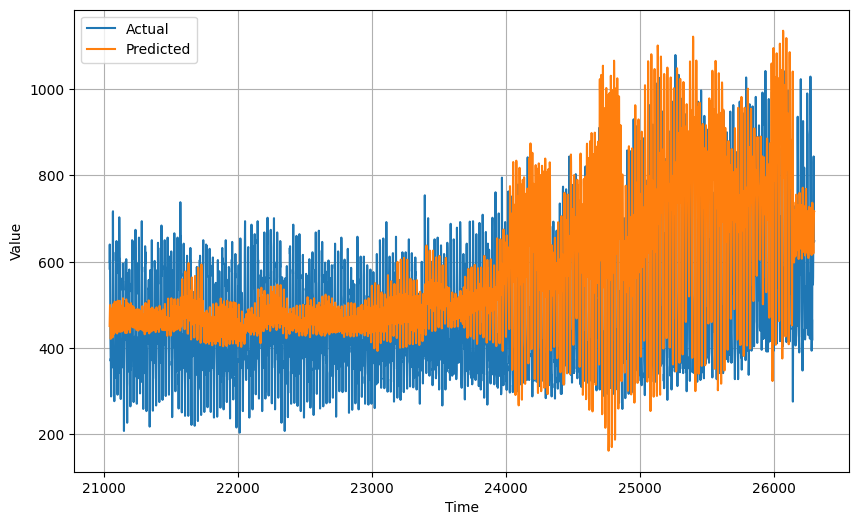

In [103]:
plt.figure(figsize=(10, 6))
plt.plot(time_valid, series_valid, label="Actual")
plt.plot(time_valid, forecast, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

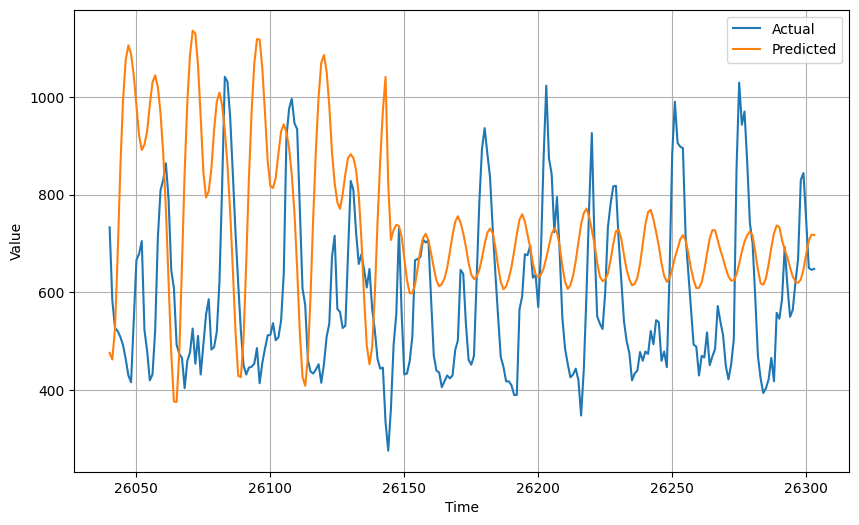

In [104]:
# ZOOMING INTO LAST 5% OF DATA POINTS
zoom_start_idx = int(0.95 * len(time_valid))

zoom_time_valid = time_valid[zoom_start_idx:]
zoom_series_valid = series_valid[zoom_start_idx:]
zoom_forecast = forecast[zoom_start_idx:]

plt.figure(figsize=(10, 6))
plt.plot(zoom_time_valid, zoom_series_valid, label="Actual")
plt.plot(zoom_time_valid, zoom_forecast, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()